In [1]:
import common
import copy
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket
import matplotlib
import matplotlib.style
import plotting
import matplotlib.ticker as ticker

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

experiments = "(hostname == 'scyper21' or hostname == 'scyper22')"

libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "llama8-ref", "sortledton", "stinger7-ref", "teseo-lcc.12"]
libraries_filter = " | ".join(map(lambda l: "library == '" + l + "'", libraries))

database = "data/new.sqlite3"

write_threads_filter = "[0, 16, 48]"

colormap= {0: "red", 16: "blue", 48: "green"}

In [2]:
data = common.import_gfe_dbms("view_mixed", database).query(experiments) # data from the experiments   

In [3]:
data_grouped = data.groupby(["library", "graph", "algorithm", "num_threads_write", "num_threads"]).agg(exec_id_min = ("exec_id", "min"), exec_id_max = ("exec_id", "max"), throughput=("throughput", "median"), analytics=("median_secs", "median"))
data_grouped

exec_id_min  \
library                            graph       algorithm num_threads_write num_threads                
livegraph3_ro                      graph500-24 bfs       16                1                    659   
                                                                           2                    660   
                                                                           4                    661   
                                                                           8                    662   
                                                                           16                   663   
                                                                           28                   664   
                                                         48                1                    665   
                                                                           8                    647   
                                                                           16                   648   
                                                                           28                   649   
                                               pagerank  16                1                    685   
                                                                           2                    686   
                                                                           4                    687   
                                                                           8                    688   
                                                                           16                   689   
                                                                           28                   690   
                                                         48                1                    692   
                                                                           2                    693   
                                                                           4                    694   
                                                                           8                    695   
                                                                           16                   696   
                                                                           28                   697   
sortledton-bfs-no-translation      graph500-24 bfs       48                1                    698   
                                                                           28                   699   
sortledton-gc-block-level-tracked  graph500-24 bfs       48                1                    711   
                                                                           28                   712   
sortledton-no-size-versioning      graph500-24 bfs       48                1                    732   
                                                                           28                   736   
                                               pagerank  48                1                    737   
                                                                           28                   738   
sortledton-no-version-chain-at-all graph500-24 bfs       48                4                    709   
                                                                           28                   708   
sortledton-no-version-chain-gc     graph500-24 bfs       48                1                    705   
                                                                           28                   706   
sortledton-steam-gc                dota-league pagerank  16                1                    757   
                                                                           2                    758   
                                                                           4                    759   
                                                                       

In [4]:
# Add isolated workload
data_analytics_isolated = common.import_gfe_dbms("view_graphalytics_updates", "data/new.sqlite3").query(experiments)
data_analytics_isolated["num_threads_write"] = 0
data_analytics_isolated_grouped = data_analytics_isolated.groupby(["library", "graph", "algorithm", "num_threads_write", "num_threads"]).agg(analytics=("median_secs", "median"))

# Add sortledton.3 as isolated workload for sortledton with steam gc
data_analytics_isolated_grouped

analytics
library               graph       algorithm num_threads_write num_threads            
livegraph3_ro         graph500-24 bfs       0                 1             14.460734
                                                              2              9.462445
                                                              4              6.414649
                                                              8              4.572362
                                                              16             3.428710
                                                              28             2.751272
                                  pagerank  0                 1            171.893523
                                                              2             90.671098
                                                              4             50.858279
                                                              8             26.930580
                                                              16            14.878426
                                                              28             9.655237
                                  sssp      0                 1            240.107031
                                                              2            143.380001
                                                              4             75.332410
                                                              8             35.582883
                                                              16            22.686649
                                                              28            13.053099
                                  wcc       0                 1             33.861857
                                                              2             20.426474
                                                              4             10.069496
                                                              8              5.616999
                                                              16             3.169416
                                                              28             2.953296
sortledton-steam-gc-1 graph500-24 bfs       0                 1              2.543796
                                                              2              1.317311
                                                              4              0.710522
                                                              8              0.416475
                                                              16             0.260584
                                                              32             0.207605
                                  pagerank  0                 1             69.966040
                                                              2             35.399833
                                                              4             17.760468
                                                              8              9.490081
                                                              16             4.910359
                                                              32             2.904902
                                  sssp      0                 1            109.302657
                                                              2             50.030254
                                                              4             25.881098
                                                              8             12.710368
                                                              16             8.231505
                                                              32             4.715248
                                  wcc       0                 1             15.047844
                                                              2              7.678658
                                                              4              3.637448
                                  

In [5]:
throughput_isoloated = common.import_gfe_dbms("view_updates_mean", "data/new.sqlite3").query("is_mixed_workload == 0").query(experiments)
throughput_isoloated["num_threads"] = 0
throughput_isoloated_pr = copy.copy(throughput_isoloated)
throughput_isoloated_pr ["algorithm"] = "pagerank"
throughput_isoloated["algorithm"] = "bfs"
co = pd.concat([throughput_isoloated, throughput_isoloated_pr])
throughput_isoloated_grouped = co.groupby(["library", "graph", "algorithm", "num_threads_write", "num_threads"]).agg(throughput=("average_throughput", "mean"))
throughput_isoloated_grouped

throughput
library               graph       algorithm num_threads_write num_threads              
livegraph3_ro         graph500-24 bfs       16                0            2.949922e+05
                                            20                0            3.269058e+05
                                            48                0            3.279703e+05
                                  pagerank  16                0            2.949922e+05
                                            20                0            3.269058e+05
                                            48                0            3.279703e+05
sortledton-steam-gc   dota-league bfs       16                0            1.697144e+06
                                            48                0            3.261454e+06
                                  pagerank  16                0            1.697144e+06
                                            48                0            3.261454e+06
                      graph500-24 bfs       16                0            1.759305e+06
                                            48                0            3.400953e+06
                                  pagerank  16                0            1.759305e+06
                                            48                0            3.400953e+06
sortledton-steam-gc-1 graph500-24 bfs       16                0            1.413485e+06
                                            48                0            2.371505e+06
                                  pagerank  16                0            1.413485e+06
                                            48                0            2.371505e+06
sortledton-steam-gc-2 graph500-24 bfs       16                0            1.795026e+06
                                            48                0            3.464789e+06
                                  pagerank  16                0            1.795026e+06
                                            48                0            3.464789e+06
sortledton.3          graph500-24 bfs       16                0            1.893169e+06
                                            48                0            3.637708e+06
                                            56                0            3.724117e+06
                                  pagerank  16                0            1.893169e+06
                                            48                0            3.637708e+06
                                            56                0            3.724117e+06
sortledton.4          graph500-24 bfs       16                0            1.869386e+06
                                            48                0            3.428929e+06
                                            56                0            3.787401e+06
                                  pagerank  16                0            1.869386e+06
                                            48                0            3.428929e+06
                                            56                0            3.787401e+06

In [6]:
data_all = pd.concat([data_grouped, data_analytics_isolated_grouped, throughput_isoloated_grouped])
data_all

exec_id_min  \
library                            graph       algorithm num_threads_write num_threads                
livegraph3_ro                      graph500-24 bfs       16                1                  659.0   
                                                                           2                  660.0   
                                                                           4                  661.0   
                                                                           8                  662.0   
                                                                           16                 663.0   
                                                                           28                 664.0   
                                                         48                1                  665.0   
                                                                           8                  647.0   
                                                                           16                 648.0   
                                                                           28                 649.0   
                                               pagerank  16                1                  685.0   
                                                                           2                  686.0   
                                                                           4                  687.0   
                                                                           8                  688.0   
                                                                           16                 689.0   
                                                                           28                 690.0   
                                                         48                1                  692.0   
                                                                           2                  693.0   
                                                                           4                  694.0   
                                                                           8                  695.0   
                                                                           16                 696.0   
                                                                           28                 697.0   
sortledton-bfs-no-translation      graph500-24 bfs       48                1                  698.0   
                                                                           28                 699.0   
sortledton-gc-block-level-tracked  graph500-24 bfs       48                1                  711.0   
                                                                           28                 712.0   
sortledton-no-size-versioning      graph500-24 bfs       48                1                  732.0   
                                                                           28                 736.0   
                                               pagerank  48                1                  737.0   
                                                                           28                 738.0   
sortledton-no-version-chain-at-all graph500-24 bfs       48                4                  709.0   
                                                                           28                 708.0   
sortledton-no-version-chain-gc     graph500-24 bfs       48                1                  705.0   
                                                                           28                 706.0   
sortledton-steam-gc                dota-league pagerank  16                1                  757.0   
                                                                           2                  758.0   
                                                                           4                  759.0   
                                                                       

## Slow down analytical vs isolated analytical

In [7]:
def slow_down(data, library, algorithm):
    data_filtered = data_all.loc[(library, "graph500-24", algorithm)]
    data_filtered = data_filtered.query("num_threads != 0 and num_threads_write != 0")
    base_library = 'sortledton.3' if library.startswith('sortledton') else library
    return data_filtered['analytics'] / data_all.loc[(base_library, "graph500-24", algorithm, 0)]['analytics']
slow_down_sorltedton_bfs = slow_down(data, 'sortledton.4', 'bfs')
slow_down_sorltedton_bfs

<ipython-input-7-b278cb267225>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_filtered = data_all.loc[(library, "graph500-24", algorithm)]
<ipython-input-7-b278cb267225>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  return data_filtered['analytics'] / data_all.loc[(base_library, "graph500-24", algorithm, 0)]['analytics']


num_threads_write  num_threads
16                 1              2.656443
                   2              2.807209
                   4              2.795147
                   8              2.716898
                   16             2.554942
                   32                  NaN
48                 1              3.752291
                   2              4.041976
                   4              3.923993
                   8              3.893390
                   16             4.396385
                   32                  NaN
Name: analytics, dtype: float64

In [8]:
slow_down_sortledton_pr = slow_down(data, 'sortledton.4', 'pagerank')
slow_down_sortledton_pr

<ipython-input-7-b278cb267225>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_filtered = data_all.loc[(library, "graph500-24", algorithm)]
<ipython-input-7-b278cb267225>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  return data_filtered['analytics'] / data_all.loc[(base_library, "graph500-24", algorithm, 0)]['analytics']


num_threads_write  num_threads
16                 1               4.025545
                   2               3.405510
                   4               3.293922
                   8               2.697923
                   16              2.635080
                   32                   NaN
48                 1              17.809143
                   2               9.841675
                   4               6.964705
                   8               5.871014
                   16              4.488908
                   32                   NaN
Name: analytics, dtype: float64

In [9]:
slow_down_livegraph_bfs = slow_down(data, 'livegraph3_ro', 'bfs')
slow_down_livegraph_bfs

<ipython-input-7-b278cb267225>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_filtered = data_all.loc[(library, "graph500-24", algorithm)]
<ipython-input-7-b278cb267225>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  return data_filtered['analytics'] / data_all.loc[(base_library, "graph500-24", algorithm, 0)]['analytics']


num_threads_write  num_threads
16                 1              1.130872
                   2              1.096859
                   4              1.071057
                   8              1.063479
                   16             1.035693
                   28             1.059993
48                 1              1.339378
                   8              1.328041
                   16             1.304114
                   28             1.301997
Name: analytics, dtype: float64

In [10]:
slow_down_livegraph_pr = slow_down(data, 'livegraph3_ro', 'pagerank')
slow_down_livegraph_pr

<ipython-input-7-b278cb267225>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_filtered = data_all.loc[(library, "graph500-24", algorithm)]
<ipython-input-7-b278cb267225>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  return data_filtered['analytics'] / data_all.loc[(base_library, "graph500-24", algorithm, 0)]['analytics']


num_threads_write  num_threads
16                 1              1.421704
                   2              1.363207
                   4              1.256899
                   8              1.205108
                   16             1.168182
                   28             1.251656
48                 1              1.895789
                   2              1.836791
                   4              1.665923
                   8              1.667807
                   16             1.559658
                   28             1.454109
Name: analytics, dtype: float64

## Analytical results with varying threads

In [11]:
def analytical_performance(data, graph, algorithm, library):
    data_analytics = data.drop("throughput", axis=1)

    # Remove NaN values
    data_analytics = data_analytics.query("analytics == analytics")

    # Which algorithm?
    data_analytics = data_analytics.query("algorithm == '%s'" % algorithm)

    # Which graph?
    data_analytics = data_analytics.query("graph == '%s'" % graph)
    
    data_analytics = data_analytics.query("library == '%s'" % library)

    # Remove dirty data
    data_analytics = data_analytics.query("num_threads_write in %s" % write_threads_filter)
    
    return data_analytics.pivot_table('analytics', index='num_threads', columns='num_threads_write')

graph500_bfs_analytical_sorltedton = analytical_performance(data_all, 'graph500-24', 'bfs', 'sortledton.4')
graph500_pagerank_analytical_sorltedton = analytical_performance(data_all, 'graph500-24', 'pagerank', 'sortledton.4')

graph500_bfs_analytical_livegraph = analytical_performance(data_all, 'graph500-24', 'bfs', 'livegraph3_ro')
graph500_pagerank_analytical_livegraph = analytical_performance(data_all, 'graph500-24', 'pagerank', 'livegraph3_ro')

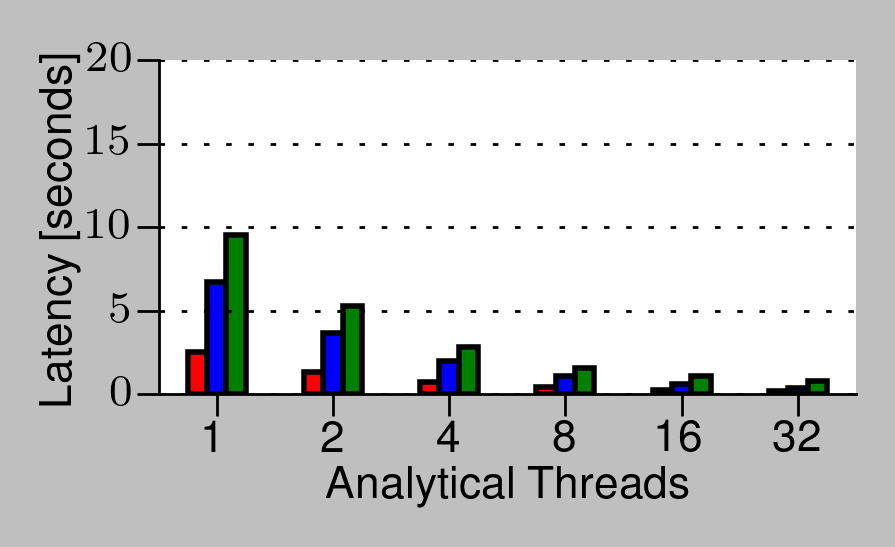

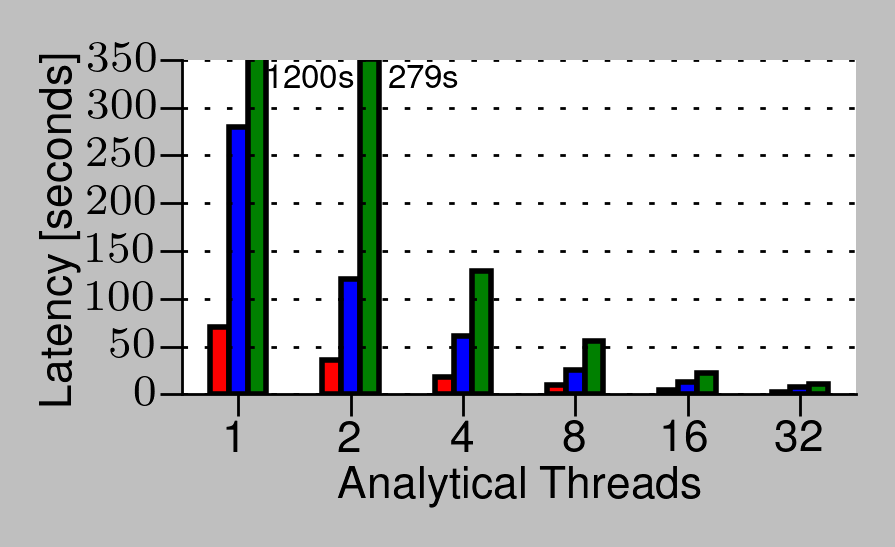

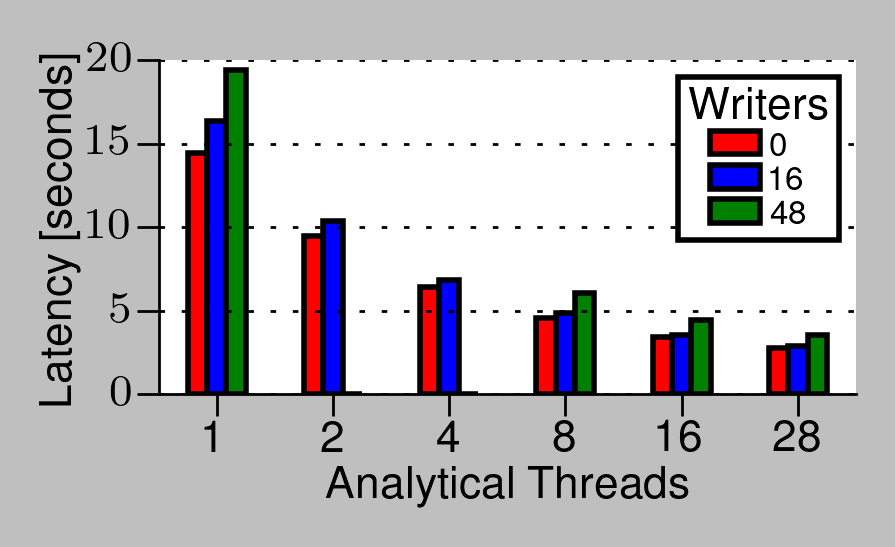

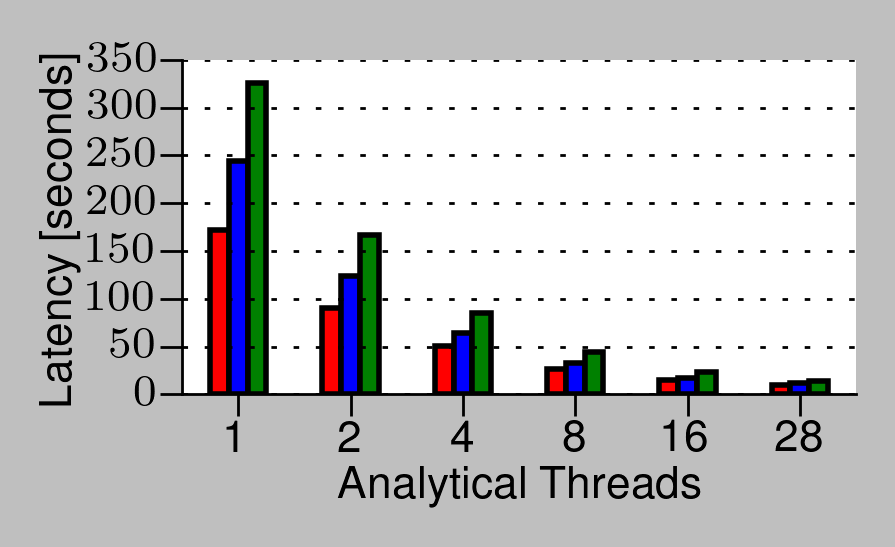

In [12]:
def plot_analytics(data, graph, algorithm, library, extra_code=None, legend=False):
    matplotlib.style.use('classic')
    plotting.latexify(columns=3)

    p = data.plot.bar(color=colormap)
    p.legend(title="Writers")

    plt.xlabel("Analytical Threads")
    plt.ylabel("Latency [seconds]")
    #plt.title("Systems: %s Algorithm: %s Dataset: %s" % (library, algorithm, graph))

    plt.xticks(rotation=0)
    plotting.format_axes(p, yscale="linear")
    
    if extra_code is not None:
        extra_code(p)
        
    if not legend:    
        p.get_legend().remove()    
    
    plt.tight_layout()
    plt.savefig(plotting.base_path + "mixed-analytics-%s-%s.png" % (library, algorithm), dpi=400)

def extra_bfs(p):
    plt.ylim(0, 20)
    
def extra_pr_sortledton(p):
    extra_pr(p)
    p.text(0.303, 0.83, "1200s", fontsize="6", transform=plt.gcf().transFigure)
    p.text(0.435, 0.83, "279s", fontsize="6", transform=plt.gcf().transFigure)
    
    
def extra_pr(p):
    plt.ylim(0, 350)

plot_analytics(graph500_bfs_analytical_sorltedton, 'graph500-24', 'bfs', 'sortledton', extra_bfs)
plot_analytics(graph500_pagerank_analytical_sorltedton, 'graph500-24', 'pr', 'sortledton', extra_pr_sortledton)
plot_analytics(graph500_bfs_analytical_livegraph, 'graph500-24', 'bfs', 'livegraph', extra_bfs, True)
plot_analytics(graph500_pagerank_analytical_livegraph, 'graph500-24', 'pagerank', 'livegraph', extra_pr)

This plot should be read in groups of three bars each. The most left of each group of three is an isolated BFS then a BFS with 16 update threads, then a BFS with 48 update threads. From left to right we increase the number of threads used for the BFS. 

We see that running the isolated BFS is slower than with 16 threads writing in parallel. This is most likely due to differences in the workload when not all edges are included yet.

Adding additional threads to the BFS pays off until 8 threads. After, we see no positive effect anymore. Actually, we see slow down. Is this hinting at contention?

In [13]:
def update_throuphput(data, graph, algorithm, library):
    data_throughput = data
    data_throughput = data_throughput.drop("analytics", axis=1)
    data_throughput = data_throughput.query("graph == '%s' and throughput == throughput and algorithm == '%s' and library == '%s'" % (graph, algorithm, library))
    
    data_throughput = data_throughput.query("num_threads_write in %s" % write_threads_filter)
    
    return data_throughput.pivot_table('throughput', index='num_threads', columns='num_threads_write')
    
graph500_bfs_throughput_sortledton = update_throuphput(data_all, 'graph500-24', 'bfs', 'sortledton.4')
graph500_pagerank_throughput_sortledton = update_throuphput(data_all, 'graph500-24', 'pagerank', 'sortledton.4')

graph500_bfs_throughput_livegraph = update_throuphput(data_all, 'graph500-24', 'bfs', 'livegraph3_ro')
graph500_pagerank_throughput_livegraph = update_throuphput(data_all, 'graph500-24', 'pagerank', 'livegraph3_ro')

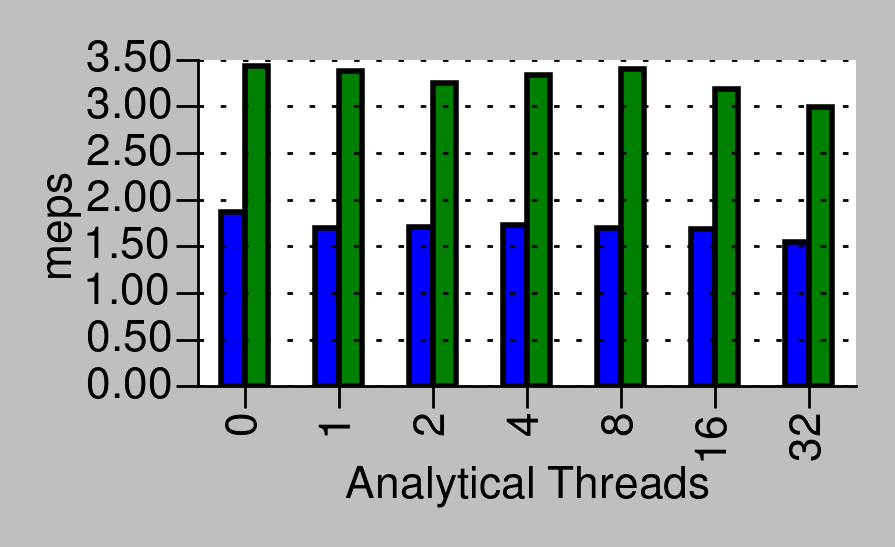

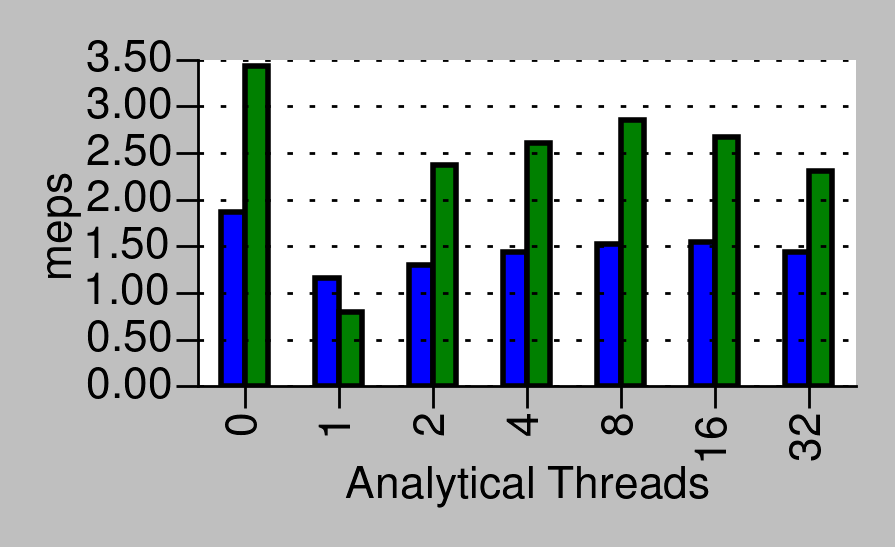

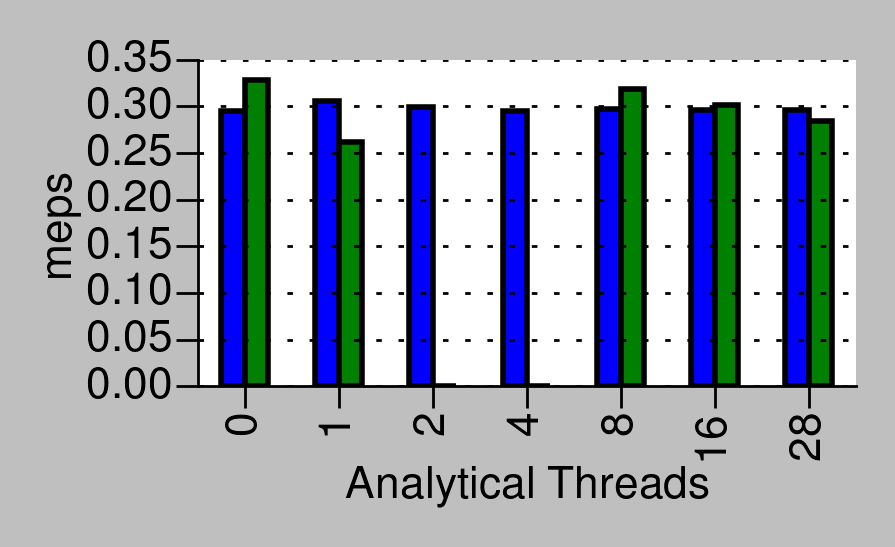

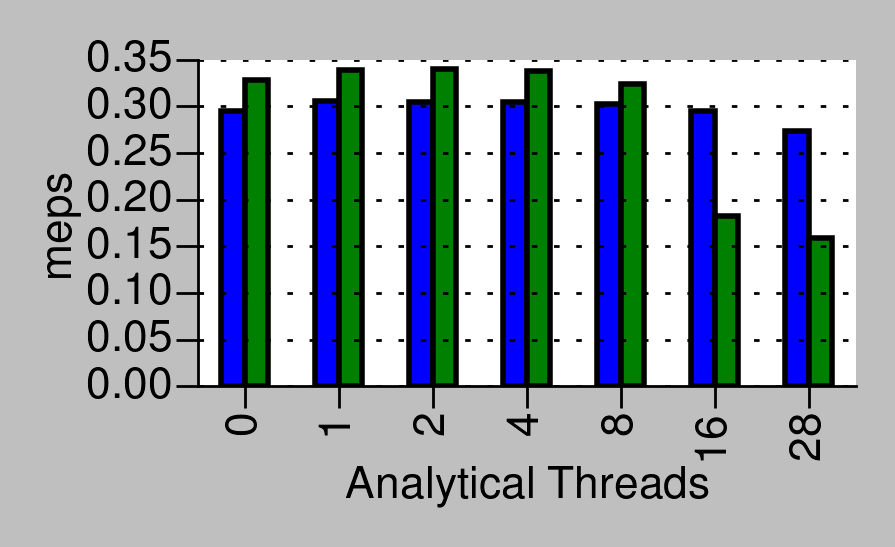

In [14]:
def plot_throughput(data, graph, algorithm, library):
    matplotlib.style.use('classic')
    plotting.latexify(columns=3)
    
    p = data.plot.bar(legend=None, color=colormap)
    #p.legend(title="Writers")

    plt.ylabel("meps")
    plt.xlabel("Analytical Threads")
    #plt.title("Library: %s, Algorithm: %s, Graph: %s" % (library, algorithm, graph))
    
    scale_y = 1e6
    ticks_y = ticker.FuncFormatter(lambda x, pos: '%.2f' % ( float(x) / scale_y))
    #p.yaxis.set_major_locator(ticker.MultipleLocator(scale_y))
    p.yaxis.set_major_formatter(ticks_y)
    plt.yticks()

    plotting.format_axes(p, yscale="linear")
    plt.tight_layout()
    plt.savefig(plotting.base_path + "mixed-throughput-%s-%s.png" % (library, algorithm), dpi=400)

plot_throughput(graph500_bfs_throughput_sortledton, 'graph500-24', 'bfs', 'sortledton')
plot_throughput(graph500_pagerank_throughput_sortledton, 'graph500-24', 'pagerank', 'sortledton')

plot_throughput(graph500_bfs_throughput_livegraph, 'graph500-24', 'bfs', 'livegraph')
plot_throughput(graph500_pagerank_throughput_livegraph, 'graph500-24', 'pagerank', 'livegraph')
#plot_throughput(dota_league_bfs_throughput, 'graph500-24', 'bfs')